In [3]:
import shap
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Load model and scaler
model = joblib.load("../models/rf_model.pkl")
scaler = joblib.load("../models/scaler.pkl")

# Load your descriptors and test data (same as in model training)
X_test = pd.read_csv("../data/X_test.csv")
X_test_scaled = scaler.transform(X_test)


In [4]:
# Create SHAP explainer
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer(X_test_scaled)



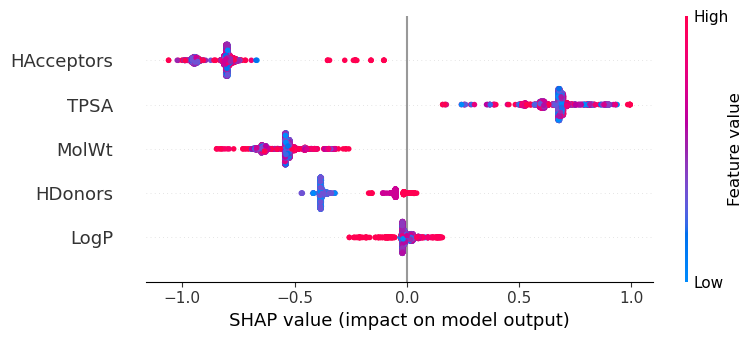

In [5]:
# Feature names
feature_names = X_test.columns

# Summary plot (beeswarm)
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)


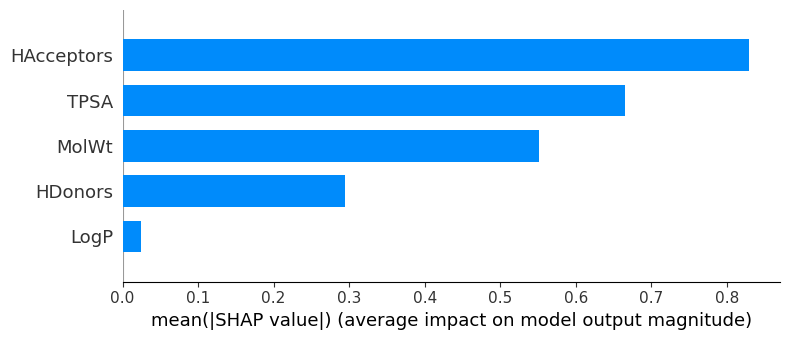

In [6]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, plot_type="bar")


In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import pandas as pd
import itertools
df = pd.read_csv("../data/chembl_egfr_bioactivity_clean.csv")


In [8]:
def get_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    return None

df["fp"] = df["Smiles"].apply(get_fingerprint)
df = df[df["fp"].notnull()].copy()


[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerator
[16:42:44] DEPRECATION WARNING: please use MorganGenerat

In [12]:
activity_cliffs = []

for i, j in itertools.combinations(df.index, 2):
    sim = DataStructs.TanimotoSimilarity(df.loc[i, "fp"], df.loc[j, "fp"])
    delta_pIC50 = abs(df.loc[i, "pIC50"] - df.loc[j, "pIC50"])
    
    if sim >= 0.85 and delta_pIC50 >= 1.0:
        activity_cliffs.append({
            "Mol1": df.loc[i, "Smiles"],
            "Mol2": df.loc[j, "Smiles"],
            "pIC50_1": df.loc[i, "pIC50"],
            "pIC50_2": df.loc[j, "pIC50"],
            "ΔpIC50": delta_pIC50,
            "Similarity": sim
        })

ac_df = pd.DataFrame(activity_cliffs)
ac_df.to_csv("../data/activity_cliffs.csv", index=False)
print(f"✅ Found {len(ac_df)} activity cliffs. Saved to ../data/activity_cliffs.csv")


✅ Found 49895 activity cliffs. Saved to ../data/activity_cliffs.csv


In [15]:
from rdkit import Chem
from rdkit.Chem import Draw

import pandas as pd

# Load the cliff pairs
ac_df = pd.read_csv("../data/activity_cliffs.csv")

# Prepare top 5 cliff pairs
top_cliffs = ac_df.sort_values("ΔpIC50", ascending=False).head(5)

# Convert to RDKit Mol objects
top_cliffs["Mol1_obj"] = top_cliffs["Mol1"].apply(Chem.MolFromSmiles)
top_cliffs["Mol2_obj"] = top_cliffs["Mol2"].apply(Chem.MolFromSmiles)


In [17]:
from rdkit.Chem import Draw

# Combine all mols for the grid
mols = []
legends = []

for _, row in top_cliffs.iterrows():
    mols.append(row["Mol1_obj"])
    legends.append(f"pIC50: {row['pIC50_1']:.2f}")
    mols.append(row["Mol2_obj"])
    legends.append(f"pIC50: {row['pIC50_2']:.2f}")

# Draw grid
img = Draw.MolsToGridImage(
    mols,
    molsPerRow=2,
    subImgSize=(300, 300),
    legends=legends,
    useSVG=False,  # Ensures a PIL image is returned
    returnPNG=False  # Ensures a PIL image is returned
)


# Save
img.save("../figures/activity_cliffs_grid.png")
print("✅ Grid image saved to figures/activity_cliffs_grid.png")


✅ Grid image saved to figures/activity_cliffs_grid.png
